# Augmented Inverse Probability of Treatment Weights
Augmented-IPTW (AIPTW) is a doubly robust estimator. Essentially, AIPTW combines the IPTW estimator and g-formula into a single estimate. Before continuing, I will briefly outline what a doubly-robust estimator is and why you would want to use one. In observational research with high-dimensional data, we (generally) are forced to use parametric models to adjust for many confounders. In this scenario, we assume that our parametric models are correctly specified. Our statistical model, $\mathcal{M}$, must include the distribution that the data came from. 

With other estimators, like IPTW or g-formula, we have one chance to specify $\mathcal{M}$ correctly. Doubly-robust estimators use a model to predict the treatment (like IPTW) and another model to predict the outcome (like g-formula). The estimator then combines the estimates, such that if either is correct, then our estimate will be consistent. Essentially, we get two chances to get the statistical model correct.

A more in-depth description of doubly robust estimators is available in [this pre-print](https://statnav.files.wordpress.com/2017/10/doublerobustness-preprint.pdf)

## AIPTW

AIPTW takes the following form
$$E[Y^a] = \frac{1}{n} \sum_i^n \left(\frac{Y \times I(A=a)}{\widehat{\Pr}(A=a|L)} - \frac{\hat{E}[Y|A=a, L] \times (I(A=a) - \widehat{\Pr}(A=a|L))}{1 - \widehat{\Pr}(A=a|L)}\right)$$
where $\widehat{\Pr}(A=a|L)$ comes from the IPTW model and $\hat{E}[Y|A=a,L]$ comes from the g-formula

## An example
To motivate our example, we will use a simulated data set included with *zEpid*. In the data set, we have a cohort of HIV-positive individuals. We are interested in the sample average treatment effect of antiretroviral therapy (ART) on all-cause mortality at 45-weeks. Based on substantive background knowledge, we believe that the treated and untreated population are exchangeable based gender, age, CD4 T-cell count, and detectable viral load. 

In [1]:
import warnings
import numpy as np
import pandas as pd

from zepid import load_sample_data, spline
from zepid.causal.doublyrobust import AIPTW

df = load_sample_data(False)
df[['age_rs1', 'age_rs2']] = spline(df, 'age0', n_knots=3, term=2, restricted=True)
df[['cd4_rs1', 'cd4_rs2']] = spline(df, 'cd40', n_knots=3, term=2, restricted=True)

df = df.drop(columns=['cd4_wk45'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 0 to 546
Data columns (total 12 columns):
id         547 non-null int64
male       547 non-null int64
age0       547 non-null int64
cd40       547 non-null int64
dvl0       547 non-null int64
art        547 non-null int64
dead       517 non-null float64
t          547 non-null float64
age_rs1    547 non-null float64
age_rs2    547 non-null float64
cd4_rs1    547 non-null float64
cd4_rs2    547 non-null float64
dtypes: float64(6), int64(6)
memory usage: 55.6 KB


Our data is now ready to conduct a complete case analysis using AIPTW. First, we initialize AIPTW with our complete-case data (`dfcc`), the treatment (`art`), and the outcome (`dead`)

In [2]:
aipw = AIPTW(df, exposure='art', outcome='dead')

### Treatment Model
First, we will specify our treatment model. We believe the sufficient set for the treatment model is gender (`male`), age (`age0`), CD4 T-cell (`cd40`) and detectable viral load (`dvl0`). To relax the functional for assumptions, we will model age and CD4 using restricted quadratic splines

In [3]:
aipw.exposure_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')


----------------------------------------------------------------
MODEL: art ~ male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0
-----------------------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    art   No. Observations:                  547
Model:                            GLM   Df Residuals:                      538
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -214.63
Date:                Wed, 17 Jul 2019   Deviance:                       429.26
Time:                        12:32:16   Pearson chi2:                     539.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]

`AIPTW` uses a logistic regression model to estimate the probabilities of treatment and the corresponding summary of the model fit are printed to the console. 

### Outcome Model
Now, we will estimate the outcome model. We will model the outcomes as ART (`art`), gender (`male`), age (`age0`), CD4 T-cell (`cd40`) and detectable viral load (`dvl0`). Again, we will model age and CD4 using restricted quadratic splines 

In [4]:
aipw.outcome_model('art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')


----------------------------------------------------------------
MODEL: dead ~ art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0
-----------------------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   dead   No. Observations:                  517
Model:                            GLM   Df Residuals:                      507
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -202.85
Date:                Wed, 17 Jul 2019   Deviance:                       405.71
Time:                        12:32:16   Pearson chi2:                     535.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025     

Again, logistic regression is used to predict the outcome data

### Estimation
To estimate the risk difference and risk ratio, we will now call the `fit()` function. After this, `AIPTW` gains the attributes `risk_difference` and `risk_ratio`. Additionally, results can be printed to the console using the `summary()` function

In [5]:
aipw.fit()
aipw.summary()

          Augmented Inverse Probability of Treatment Weights          
Treatment:        art             No. Observations:     547                 
Outcome:          dead            No. Missing Outcome:  30                  
g-Model:          Logistic        Q-model:              Logistic            
Missing model:    None           
Risk Difference:     -0.084
95.0% two-sided CI: (-0.153 , -0.014)
----------------------------------------------------------------------
Risk Ratio:         0.54
95.0% two-sided CI: -


c:\users\zivic\python programs\development\zepid\zepid\causal\doublyrobust\AIPW.py:337: UserWarning: All missing outcome data is assumed to be missing completely at random. To relax this assumption to outcome data is missing at random please use the `missing_model()` function
  "function", UserWarning)


Interpreting the risk difference, we would conclude that had everyone in our cohort been treated with ART, the risk of all-cause mortality would have been 8.4% (95% CL: -0.153, -0.014) points lower than had no one been treated.

Confidence intervals come for influence curves. They are currently only available for the risk difference

### Diagnostics
`AIPTW` supports diagnostics for both the pi-model (IPTW) and the Q-model (g-formula). All available diagnostics can easily be ran using `run_diagnostics()`

	Exposure Model Diagnostics
                      Weight Positivity Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be 2
----------------------------------------------------------------------
Mean weight:            1.986
Standard Deviation:     2.366
Minimum weight:         1.06
Maximum weight:         16.919


                  Standardized Mean Differences
            smd_w     smd_u
labels                     
male    -0.088567 -0.015684
age0     0.053929  0.022311
age_rs1  0.072832  0.062384
age_rs2  0.071245  0.057444
cd40    -0.022283 -0.486700
cd4_rs1 -0.016827 -0.487005
cd4_rs2 -0.008080 -0.297140
dvl0     0.047828 -0.015729

	Outcome Model Diagnostics
                 Natural Course Prediction Accuracy
Outcome model accuracy summary statistics. Defined as the predicted
outcome value minus the observed outcome value
-----------------------------------------------

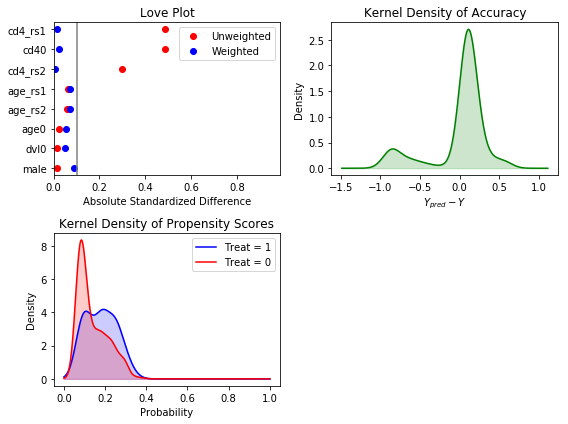

In [6]:
aipw.run_diagnostics()



### Confidence Intervals
To obtain correct confidence intervals, we can alternatively use a bootstrap procedure. For the risk ratio, you will have to use the bootstrap procedure at this point

In [7]:
rr_results = []

with warnings.catch_warnings():  # Ignoring warnings for censored data
    warnings.simplefilter("ignore")
    for i in range(1000):
        dfs = df.sample(n=df.shape[0],replace=True)
        s = AIPTW(dfs, exposure='art', outcome='dead')
        s.exposure_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                         print_results=False)
        s.outcome_model('art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                        print_results=False)
        s.fit()
        rr_results.append(s.risk_ratio)


In [8]:
print('\nRisk Ratio')
print('95% LCL', np.percentile(rr_results, q=2.5))
print('95% UCL', np.percentile(rr_results, q=97.5))


Risk Ratio
95% LCL 0.23567701608882596
95% UCL 0.9536056438173632


Once I know the influence curve confidence intervals for the risk ratio, I will add them.

## Missing Data
For censored observations (missing outcome data), an optional function can be used to generate inverse probability weights to account for informative censoring by observed variables. Below is an example where we assume censoring is non-informative conditional on the available confounders.

In [9]:
aipw = AIPTW(df, exposure='art', outcome='dead')
aipw.exposure_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0', 
                   print_results=False)
aipw.missing_model('art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                  print_results=False)
aipw.outcome_model('art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                  print_results=False)
aipw.fit()
aipw.summary()

          Augmented Inverse Probability of Treatment Weights          
Treatment:        art             No. Observations:     547                 
Outcome:          dead            No. Missing Outcome:  30                  
g-Model:          Logistic        Q-model:              Logistic            
Missing model:    Logistic       
Risk Difference:     -0.087
95.0% two-sided CI: (-0.16 , -0.015)
----------------------------------------------------------------------
Risk Ratio:         0.547
95.0% two-sided CI: -


Our results are fairly similar to the previous results. This indicates (given the assumption that our model is sufficiently flexible) that there doesn't seem to be substantial informative censoring by the observed variables.

# Conclusion
In this tutorial, I introduced the concept of doubly-robust estimators and detailed augmented-IPTW. I demonstrated estimation with `AIPTW` using *zEpid* and how to obtain confidence intervals. Please view other tutorials for information on other functionality within *zEpid*

## References
Funk MJ, Westreich D, Wiesen C, Stürmer T, Brookhart MA, Davidian M. (2011). Doubly robust estimation of causal effects. *AJE*, 173(7), 761-767.

Lunceford JK, Davidian M. (2004). Stratification and weighting via the propensity score in estimation of causal treatment effects: a comparative study. *SiM*, 23(19), 2937-2960.

Keil AP et al. (2018). Resolving an apparent paradox in doubly robust estimators. *AJE*, 187(4), 891-892.

Robins JM, Rotnitzky A, Zhao LP. (1994). Estimation of regression coefficients when some regressors are not always observed. *JASA*, 89(427), 846-866.